In [1]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
from pathlib import Path


# Biocellion Output Plotting
This notebook defines functions to read and plot the biocellion output data for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  

To use these plotting functions the biocellion output summary should be in one directory with the following naming pattern:
`output_parameter{par_id}_trial{trial}.txt`

If the scripts and instructions in https://github.com/TheCMMC/biocellion-tools have been used to create the output, this notebook should be able to run with the resulting data.

## User settings

In [55]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/biocellion-data")
MODEL_OUTPUT_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output")
FIG_FOLDER = Path("./figures")

## Plotting functions

In [3]:
ABM_ONLY_FOLDER = DATA_FOLDER / "PLOSone_ABM-only-microcarrier"
ABM_CFD_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"

In [58]:
def read_summary_file(filename):
    live, attached, dead, removed = ([],[],[],[])

    with open(filename, 'r' ) as f :
        for line in f:
            if 'Live Cells' in line :
              live.append( int( line.strip().split(':')[-1] ) )
            if 'Live Attached Cells' in line :
              attached.append( int( line.strip().split(':')[-1] ) )
            elif 'Death Cells' in line:
              dead.append( int( line.strip().split(':')[-1] ))
            elif 'Removed Cells' in line :
              removed.append( int( line.strip().split(':')[-1] ))
    
    # if the lengths of these list are different print error
    assert len(live)==len(attached)==len(dead)==len(removed), "Cell count lists are of different lenghts"

    return {"live":live, "attached":attached, "dead":dead, "removed":removed}

def plot_single_summary(par_id, trial, data_folder, legend=True, fig=None, ax=None):
    filename = data_folder / f"output_parameter{par_id}_trial{trial}.txt"
    cell_counts = read_summary_file(filename)

    Npoints = len( cell_counts["live"] )
    tsteps = range( Npoints)
    
    if fig==None:
        fig, ax = plt.subplots()
    
    ax.plot(tsteps, cell_counts["live"], '-b', label='Live')
    ax.plot(tsteps, cell_counts["attached"], '-g', label='Attached')
    ax.plot(tsteps, cell_counts["dead"], '-r', label='Apoptotic')
    ax.plot(tsteps, cell_counts["removed"], '-k', label='Dead')
    
    if legend:
        leg = ax.legend()
    
    plt.title(f'parameter set: {par_id}, trial: {trial}')
    plt.ylabel('Cell count (one microcarrier)')
    plt.xlabel('Time steps')
#     plt.savefig(f"cell_counts_parameter{par_id}_trial{trial}.png", dpi=150)
    
def plot_multi_summary(par_ids, trials, data_folder, states=["live", "attached", "dead", "removed"]):
    for par_id in par_ids:
        fig, ax = plt.subplots()
        for trial in trials:
            plot_single_summary(par_id, trial, data_folder, False, fig, ax)
            plt.savefig(FIG_FOLDER / f"cell_counts_parameter{par_id}.png", dpi=150)
            plt.title(f'parameter set: {par_id}, all (10) trials')



<ipython-input-58-87db42f60f0e>:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


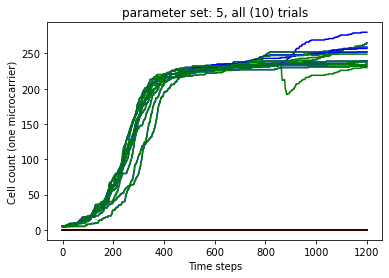

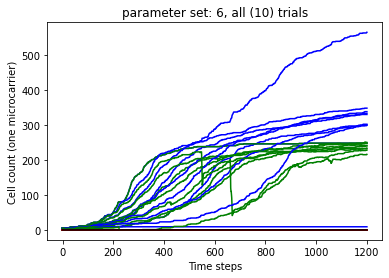

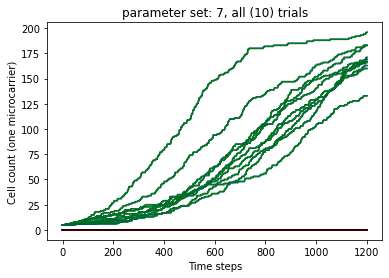

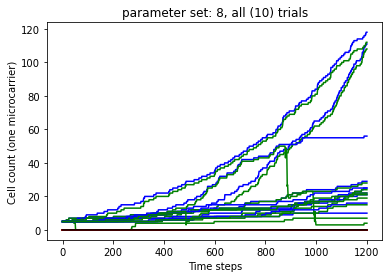

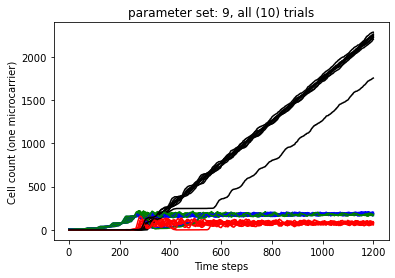

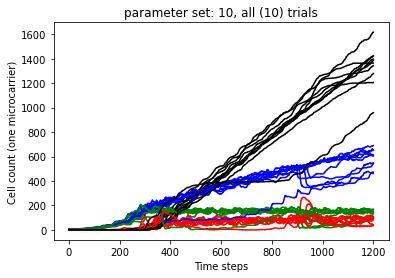

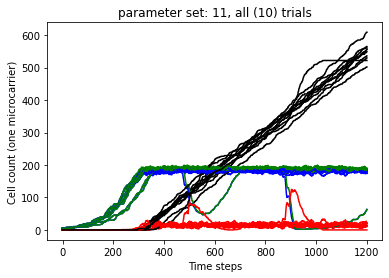

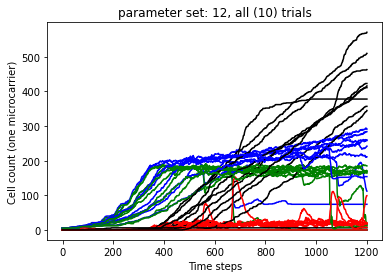

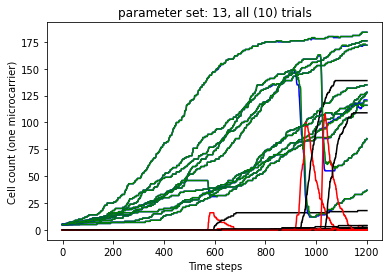

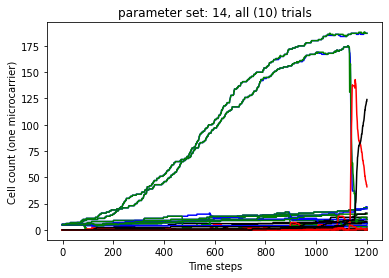

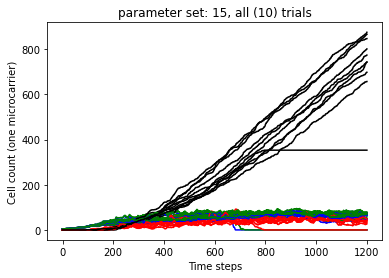

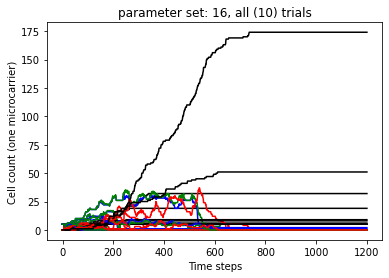

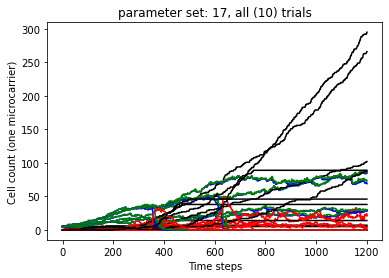

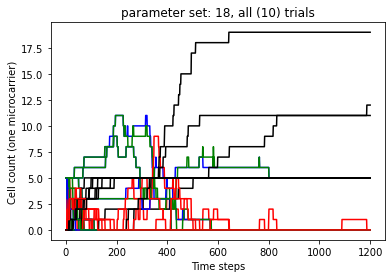

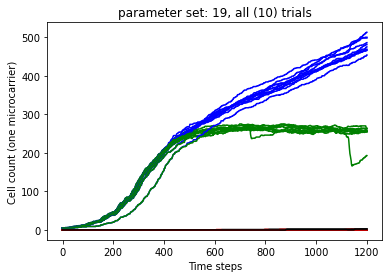

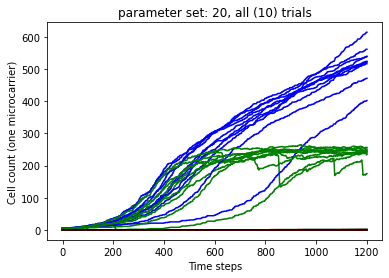

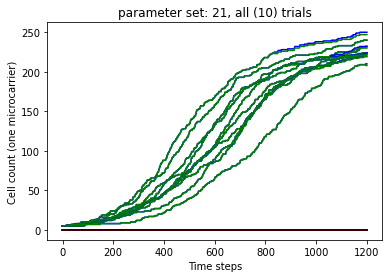

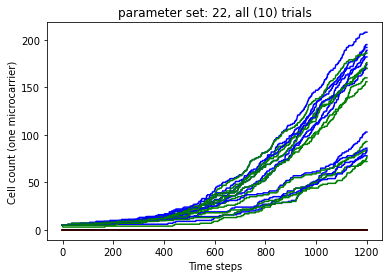

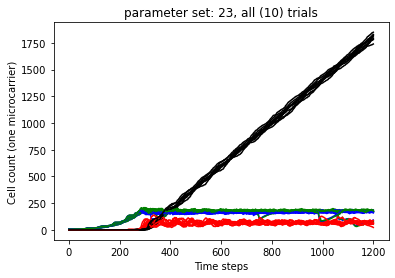

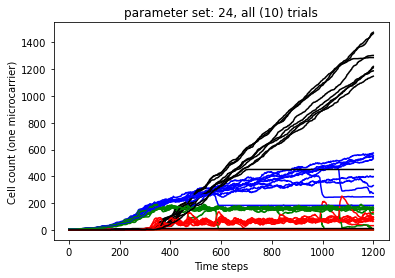

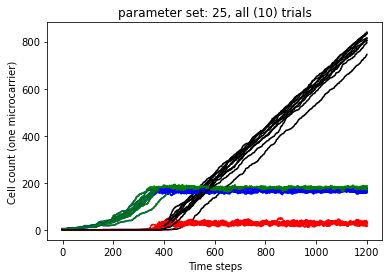

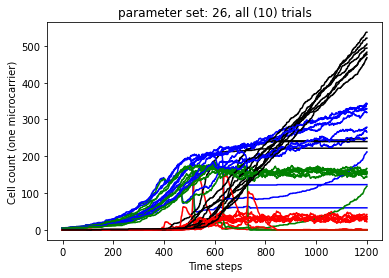

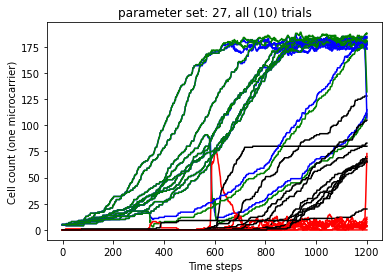

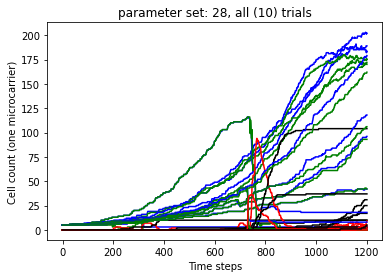

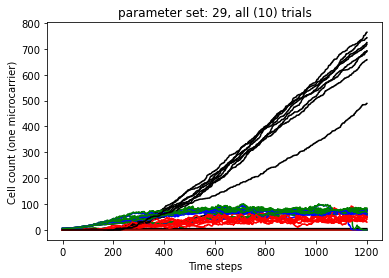

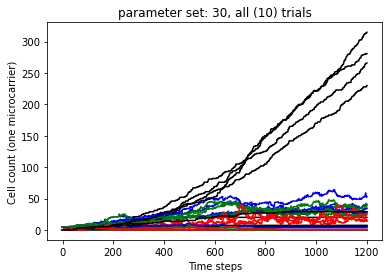

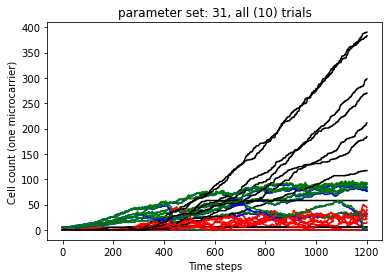

In [59]:
plot_multi_summary(range(5,32), range(1,11), ABM_CFD_FOLDER)

In [30]:
def read_pvtp_files(pvtp_folder, nsteps, start=0, interval=1):
    pvs._DisableFirstRenderCameraReset()
    for step in range(start, nsteps, interval):
        file_name = pvtp_folder / f'agent_{str(step).zfill(5)}.pvtp'
        print(file_name)
        file = pvs.XMLPartitionedPolydataReader(FileName = str(file_name))
        print(file)
    return 
        
def plot_single_cells(par_id, trial, model_folder):
    pvtp_folder = model_folder / f"output_parameter{par_id}_trial{trial}"
#     print(pvtp_folder)
    read_pvtp_files(pvtp_folder, 75000, 0, 1000)
    return
    


In [31]:
plot_single_cells(16, 8, MODEL_OUTPUT_FOLDER)

/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter16_trial8/agent_00000.pvtp
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter16_trial8/agent_01000.pvtp
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter16_trial8/agent_02000.pvtp
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter16_trial8/agent_03000.pvtp
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter16_trial8/agent_04000.pvtp
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter16_trial8/agent_05000.pvtp
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/B